In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

from sklearn import linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, brier_score_loss

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
full_df = pd.read_csv('../../data/full_df.csv')
# train_df = pd.read_csv('../../data/train_df.csv')
# prior_df = pd.read_csv('../../data/prior_df.csv')
# test_df = pd.read_csv('../../data/test_df.csv')

In [4]:
full_df.drop('Unnamed: 0',axis=1,inplace=True)
full_df.head()

,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_reorder_ratio,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
0,112108,49302,train,1,1,3,1,4,2.000,170,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
1,112108,11109,train,1,1,3,1,4,3.333,4579,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
2,112108,43633,train,1,1,3,1,4,4.000,663,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
3,112108,22035,train,1,1,3,1,4,6.000,61241,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
4,79431,19660,train,1,36,16,2,23,4.562,57921,...,0.500,23,3238.000,17.598,30.000,2.000,8.391,0.696,0.727,0


In [5]:
#filling in null values - for previous calculations where user didn't do any reorders
full_df.product_ordered_twice_vol.fillna(0,inplace=True)
full_df.product_order_twice_ratio.fillna(0,inplace=True)
full_df.user_unique_reorder_count.fillna(0,inplace=True)
full_df.user_unique_reorder_perc.fillna(0,inplace=True)
full_df.user_total_items_after_first_order.fillna(0,inplace=True)
full_df.user_reorder_ratio.fillna(0,inplace=True)
full_df.isnull().sum()

user_id                                   0
product_id                                0
eval_set                                  0
target                                    0
order_id                                  0
user_product_count                        0
user_product_first_order                  0
user_product_last_order                   0
user_product_avg_basket_placement         0
product_ordered_vol                       0
product_reordered_vol                     0
product_ordered_once_vol                  0
product_ordered_twice_vol                 0
product_order_twice_ratio                 0
product_avg_reorders                      0
product_overall_reorder_prob              0
user_total_products                       0
user_total_products_reordered             0
user_unique_product_count                 0
user_unique_reorder_count                 0
user_unique_product_perc                  0
user_unique_reorder_perc                  0
user_total_items_after_first_ord

In [6]:
print(full_df.target.value_counts())
print(full_df.target.value_counts(normalize=True))


0    7645837
1     828824
Name: target, dtype: int64
0   0.902
1   0.098
Name: target, dtype: float64


## Splitting Data
Will first split dataset into train, test, validation sets and then do a T/T/S on training set for model tuning

In [7]:
full_df.shape

(8474661, 33)

In [8]:
np.random.seed(50)
train, test = \
        np.split(full_df.sample(frac=1, random_state=42), 
#                  [int(.8*len(full_df)), int(1*len(full_df))])
                 [int(.8*len(full_df))])                 

In [9]:
print(train.shape) #80%
print(test.shape) #20%

(6779728, 33)
(1694933, 33)


In [10]:
X= train.drop(["target",'eval_set'],axis=1)
y= train['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_test = scaler.transform(X_test)

In [13]:
print(y_test.shape)
print(X_test.shape)

(1355946,)
(1355946, 31)


## Logistic Regression 

In [14]:
1-y_train.mean()

0.9020504511427635

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(logreg.score(X_test, y_test))

0.5032541229243715
0.9012519672612331


In [17]:
reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

In [18]:
# logit_simple = linear_model.LogisticRegression(C=1e9).fit(X_train, y_train)
# print(np.mean(y_test == logit_simple.predict(X_test)))
# logit_pred_proba = logit_simple.predict_proba(X_test)[:,1]

# cm = pd.DataFrame(metrics.confusion_matrix
#                   (y_true=y_test, y_pred=logit_pred_proba > .5), 
#                   columns=['Negative Pred', 'Positive Pred'])


In [19]:
reorder_logit_prob[reorder_logit_prob >=0.73]

array([0.73185297, 0.73446994, 0.73094955])

In [20]:
cm = pd.DataFrame(metrics.confusion_matrix
                      (y_true=y_test, y_pred=reorder_logit_prob > .8), 
                      columns=['Negative Pred', 'Positive Pred'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
fp = cm.iloc[0,1]
tp = cm.iloc[1,1]

acc = (tp+tn) / (tp+tn+fp+fn)
sen = (tp) / (tp+fn)
prec= tp / (tp+fp)
rec= tp/(tp+fn)

<ipython-input-20-220b129911ac>:11: RuntimeWarning: invalid value encountered in long_scalars
  prec= tp / (tp+fp)


Goal is to set probability threshold to different intervals, and see which threshold produces the 'best' success metric. It looks like calculated probabilities with this model cap out at 74%

In [29]:
type(y_pred)

numpy.ndarray

In [33]:
accuracy=[]
sensitivity=[]
precision=[]
recall=[]
ppv=[]

for i in np.arange(0.0,0.8,0.05):
    prob_thresh = i
    cm = pd.DataFrame(metrics.confusion_matrix
                      (y_true=y_test, y_pred=reorder_logit_prob > i), 
                      columns=['Negative Pred', 'Positive Pred'])
    tn = cm.iloc[0,0]
    fn = cm.iloc[1,0]
    fp = cm.iloc[0,1]
    tp = cm.iloc[1,1]
    
    acc = (tp+tn) / (tp+tn+fp+fn)
    sen = (tp) / (tp+fn) #summarizes how well the positive class was predicted.
    prec = tp / (tp+fp) #summarizes the fraction of examples assigned the positive class that belong to the positive class
    rec = tp/(tp+fn) #same as sensitivity 
    pp = tp / (tp+fp)
    
#     accuracy.append(acc)
#     sensitivity.append(sen)
#     precision.append(prec)
#     recall.append(rec)
#     ppv.append(pp)
#     print(i,'y_test:',y_test,'y_pred:',y_pred)

    f1=f1_score(y_test,reorder_logit_prob > i)
    brier=brier_score_loss(y_test, reorder_logit_prob > i)

    print(round(i,2),f"accuracy:{acc:.5f},sensitivity:{sen:.5f},precision:{prec:.5f},recall:{rec:.5f}, ppv:{pp:5f}")
    print("f1:",f1)
    print('loss_score:',brier)

0.0 accuracy:0.09746,sensitivity:1.00000,precision:0.09746,recall:1.00000, ppv:0.097464
f1: 0.17761685690900222
loss_score: 0.9025359416967932
0.05 accuracy:0.25684,sensitivity:0.87322,precision:0.10431,recall:0.87322, ppv:0.104309
f1: 0.18635727965945684
loss_score: 0.7431638133081996
0.1 accuracy:0.52820,sensitivity:0.57932,precision:0.11588,recall:0.57932, ppv:0.115879
f1: 0.19312712522828862
loss_score: 0.4717990244449263
0.15 accuracy:0.71458,sensitivity:0.33350,precision:0.12849,recall:0.33350, ppv:0.128492
f1: 0.18550990601179376
loss_score: 0.2854228708222894
0.2 accuracy:0.81507,sensitivity:0.18490,precision:0.14591,recall:0.18490, ppv:0.145908
f1: 0.16310387984981223
loss_score: 0.18492993083795373
0.25 accuracy:0.86357,sensitivity:0.10407,precision:0.17118,recall:0.10407, ppv:0.171183
f1: 0.1294418274140341
loss_score: 0.1364294743300987
0.3 accuracy:0.88552,sensitivity:0.06008,precision:0.20386,recall:0.06008, ppv:0.203856
f1: 0.09280850939481605
loss_score: 0.1144772726937

<ipython-input-33-67f9fbb3bbed>:19: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp+fp) #summarizes the fraction of examples assigned the positive class that belong to the positive class
<ipython-input-33-67f9fbb3bbed>:21: RuntimeWarning: invalid value encountered in long_scalars
  pp = tp / (tp+fp)


0.75 accuracy:0.90254,sensitivity:0.00000,precision:nan,recall:0.00000, ppv:  nan
f1: 0.0
loss_score: 0.09746405830320677


In [36]:
print(classification_report(y_test, y_pred))
print(f1_score(y_test,y_pred))
print(brier_score_loss(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95   1223790
           1       0.29      0.01      0.02    132156

    accuracy                           0.90   1355946
   macro avg       0.60      0.50      0.48   1355946
weighted avg       0.84      0.90      0.86   1355946

0.017248086196393314
0.09874803273876688
0.5032541229243715


## XGBoost

In [ ]:
import xgboost

## Feature Selection 

<AxesSubplot:>

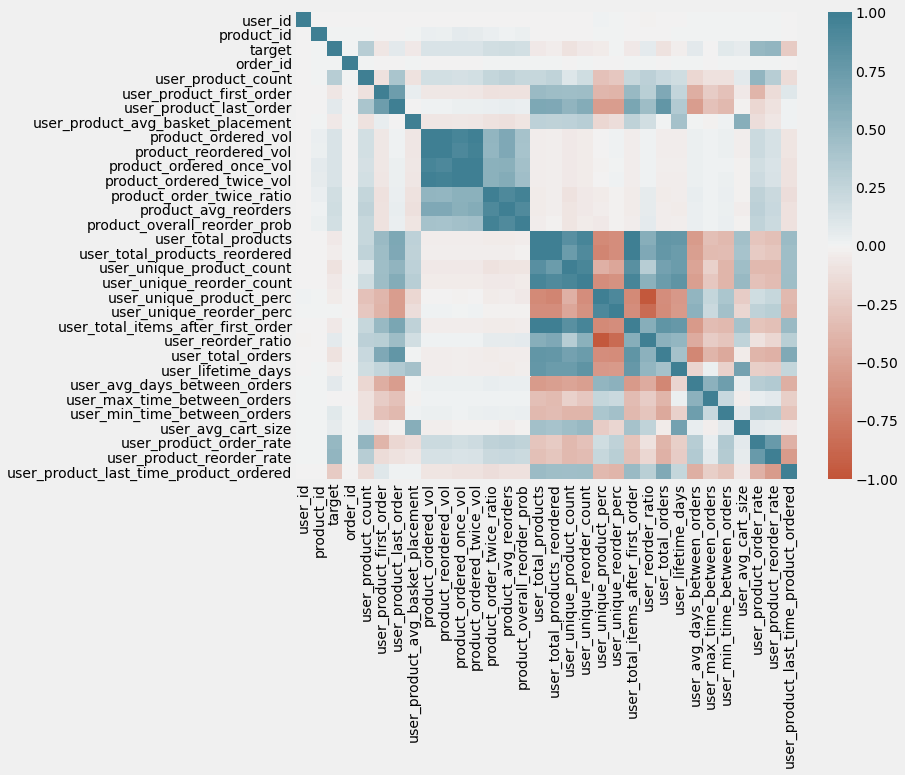

In [37]:
sns.heatmap(full_df.corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [41]:
X_model_new = SelectKBest(score_func=chi2,k=5).fit_transform(X_train,y_train)
X_model_new
# np.any(np.isnan(mat))
# np.all(np.isfinite(mat))
# X_model[X_model.isnull()]

array([[1.144293e+06, 9.260000e+02, 3.210000e+02, 6.050000e+02,
        2.980000e+02],
       [2.162359e+06, 2.018200e+04, 1.214100e+04, 8.041000e+03,
        7.360000e+03],
       [1.922250e+05, 3.320900e+04, 1.892700e+04, 1.428200e+04,
        1.319800e+04],
       ...,
       [2.445318e+06, 3.663000e+03, 1.875000e+03, 1.788000e+03,
        1.394000e+03],
       [2.694200e+04, 1.461000e+03, 2.480000e+02, 1.213000e+03,
        2.900000e+02],
       [1.515281e+06, 9.395000e+03, 3.343000e+03, 6.052000e+03,
        3.308000e+03]])